In [1]:
import qutip as qt 
#import qutip_jax
import numpy as np
from jax import jit

In [2]:
#qt.settings.core["default_dtype"] = "jax"


In [3]:
def basis_syk(N):
    if (N==1):
        prev = [qt.sigmay()/np.sqrt(2),qt.sigmax()/np.sqrt(2)]
        return prev
    else:
        prev = basis_syk(N-1)
    ops=[]
    sn= 1/np.sqrt(2)  * qt.tensor(qt.qeye(2**(N-1)),qt.sigmay())
    snm1= 1/np.sqrt(2)  * qt.tensor(qt.qeye(2**(N-1)),qt.sigmax())
    if N>1:
        ops.append(sn)
        ops.append(snm1)
        for i in prev:
            ops.append(qt.tensor(i,qt.sigmaz()))
    else:
        prev.extend(ops)
    for i in ops:
        i.dims=ops[0].dims
    return ops


def four_syk(N):
    psis = basis_syk(N)
    k = 2*N
    H = 0
    std = np.sqrt(6)*2/(N)**1.5
    J = std*np.random.rand(2*N, 2*N, 2*N, 2*N)
    for i in range(0, k):
        for j in range(i+1, k):
            for l in range(j+1, k):
                for m in range(l+1, k):
                    H += J[i, j, l, m]*psis[i]*psis[j]*psis[l]*psis[m]
    return H

In [4]:
psis=basis_syk(4)

 Building the Hamiltonian


In [5]:
def four_syk(N):
    psis=basis_syk(N)
    k=2*N
    H=0
    std= np.sqrt(6)*2/(N)**1.5
    J=std*np.random.rand(2*N,2*N,2*N,2*N)
    for i in range(0,k):
        for j in range(i+1,k):
            for l in range(j+1,k):
                for m in range(l+1,k):
                    H+=J[i,j,l,m]*psis[i]*psis[j]*psis[l]*psis[m] 
    return H

Now on to the simulation, first the pseudomode bit

In [6]:
N=3
psis=basis_syk(N)
A=four_syk(N)#ask why it takes forever with jax dia
A


Quantum object: dims=[[4, 2], [4, 2]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[-0.45816441+0.j          0.        +0.j          0.        +0.j
   0.20343998+0.0908913j   0.        +0.j          0.17799227-0.01077223j
   0.29594839+0.02686433j  0.        +0.j        ]
 [ 0.        +0.j          0.05450481+0.j         -0.2012594 -0.30375709j
   0.        +0.j          0.13249244-0.40375229j  0.        +0.j
   0.        +0.j         -0.29594839-0.02686433j]
 [ 0.        +0.j         -0.2012594 +0.30375709j  0.13903214+0.j
   0.        +0.j         -0.12324343-0.10824759j  0.        +0.j
   0.        +0.j          0.17799227-0.01077223j]
 [ 0.20343998-0.0908913j   0.        +0.j          0.        +0.j
   0.26462745+0.j          0.        +0.j          0.12324343+0.10824759j
   0.13249244-0.40375229j  0.        +0.j        ]
 [ 0.        +0.j          0.13249244+0.40375229j -0.12324343+0.10824759j
   0.        +0.j          0.26462745+0.j          0.        +0.j
   0.        +

In [7]:
from qutip.solver import heom
import numpy as np

In [8]:
oh=heom.OhmicBath(alpha=0.1,wc=5*N,s=1,T=0,Q=psis[0]) # functions don't take zero because 1/T should be fixed
times2=np.linspace(0,10,25000)
bath,finfo=oh.make_correlation_fit(times2,Ni=1,Nr=1)
print(finfo['summary']) #notice one mode is also a pretty good approximation

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 1 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 7.89e+00 |-1.64e+01 |2.17e+01                              | 1         |-9.30e+01 |-2.65e+01 |3.41e+00                              
                                                                        |                                                                        
A  normalized RMSE of  5.31e-05 was obtained for the The Real Part Of   |A  normalized RM

In [9]:
import matplotlib.pyplot as plt

/home/mcditoos/miniconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/miniconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


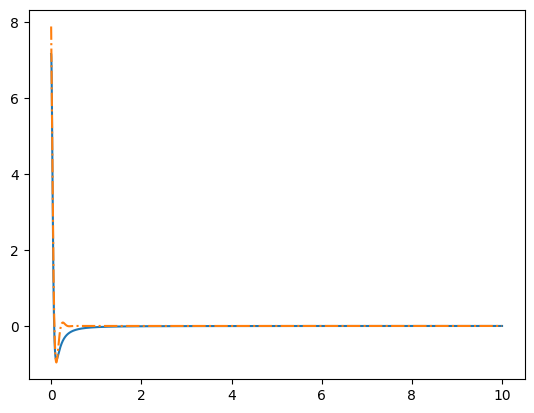

In [10]:
plt.plot(times2,bath.correlation_function(times2))
plt.plot(times2,bath.correlation_function_approx(times2),"-.")
plt.show()

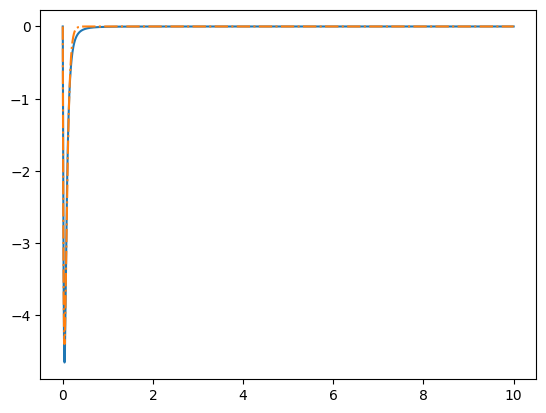

In [11]:
plt.plot(times2,np.imag(bath.correlation_function(times2)))
plt.plot(times2,np.imag(bath.correlation_function_approx(times2)),"-.")
plt.show()

In [12]:
state_list = [qt.basis(2, 0)] + [qt.basis(2, 1)] * (N - 1)
psi0 = qt.tensor(state_list)
rho0=psi0*psi0.dag()
rho0.dims=A.dims

In [13]:
(A*rho0).tr()-np.min(A.eigenenergies())

(0.9142381454070819+0j)

In [14]:
times=np.linspace(0,100,500)
solver = heom.HEOMSolver(A,
                    [bath], max_depth=3,options={"atol":1e-14})
result = solver.run(rho0, times)

10.0%. Run time:   0.84s. Est. time left: 00:00:00:07
20.0%. Run time:   1.62s. Est. time left: 00:00:00:06
30.1%. Run time:   2.37s. Est. time left: 00:00:00:05
40.1%. Run time:   3.19s. Est. time left: 00:00:00:04
50.1%. Run time:   3.93s. Est. time left: 00:00:00:03
60.1%. Run time:   4.77s. Est. time left: 00:00:00:03
70.1%. Run time:   5.60s. Est. time left: 00:00:00:02
80.2%. Run time:   6.43s. Est. time left: 00:00:00:01
90.2%. Run time:   7.26s. Est. time left: 00:00:00:00
100.0%. Run time:   8.06s. Est. time left: 00:00:00:00
Total run time:   8.06s


Solving using the bloch redfield solver

In [15]:

a_ops = [[psis[0],bath.power_spectrum]]
resultBR = qt.brmesolve(A, rho0, times, a_ops=a_ops, options={"atol": 1e-14}, sec_cutoff=-1)

a_ops = [[psis[0], bath.power_spectrum]]
resultBR2 = qt.brmesolve(A, rho0, times, a_ops=a_ops, options={
                        "atol": 1e-14})

using the cumulant equation|

In [16]:
from nmm import OhmicBath,csolve

In [17]:
help(OhmicBath)

Help on class OhmicBath in module nmm.utils.baths:

class OhmicBath(BosonicBath)
 |  OhmicBath(T, coupling, cutoff)
 |
 |  Method resolution order:
 |      OhmicBath
 |      BosonicBath
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, T, coupling, cutoff)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  correlation_function(self, t)
 |
 |  spectral_density(self, w)
 |      It describes the spectral density of an Ohmic spectral density given by
 |
 |      $$ J(\omega)= \alpha \omega e^{-\frac{|\omega|}{\omega_{c}}} $$
 |
 |      Parameters
 |      ----------
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited from BosonicBath:
 |
 |  bose(self, ν)
 |      It computes the Bose-Einstein distribution
 |
 |      $$ n(\omega)=\frac{1}{e^{\beta \omega}-1} $$
 |
 |      Parameters:
 |      ----------
 |      ν: float
 |          The mode at which to compute the thermal population
 |
 |      R

In [18]:
batho=OhmicBath(oh.T,oh.alpha/np.pi,oh.wc)
cum = csolve(Hsys=A, t=times, baths=[batho], Qs=[psis[0]], eps=1e-4, cython=False)

In [19]:
cum2 = csolve(
    Hsys=A, t=times, baths=[bath],
    Qs=[psis[0]],
    eps=1e-4, cython=False)

In [20]:
def rotation(data,H,t):
    rotated = [
        (-1j * H * t[i]).expm()
        * data[i]
        * (1j * H * t[i]).expm()
        for i in range(len(t))
    ]
    return rotated

In [21]:
result_cum = cum.evolution(rho0)
result_cum2 = cum2.evolution(rho0)

2024-07-17 07:36:55.038663: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
Computing Exponential of Generators . . . .: 100%|██████████| 500/500 [00:01<00:00, 349.12it/s]


In [22]:
result_cum =rotation(result_cum,A,times)
result_cum2 = rotation(result_cum2,A,times)

In [23]:
import matplotlib.pyplot as plt

In [24]:
sdd=[(i*A).tr() for i in result.states]
sddbr = [(i*A).tr() for i in resultBR.states]
sddcum = [(i*A).tr() for i in result_cum]
sddcum2 = [(i*A).tr() for i in result_cum2]

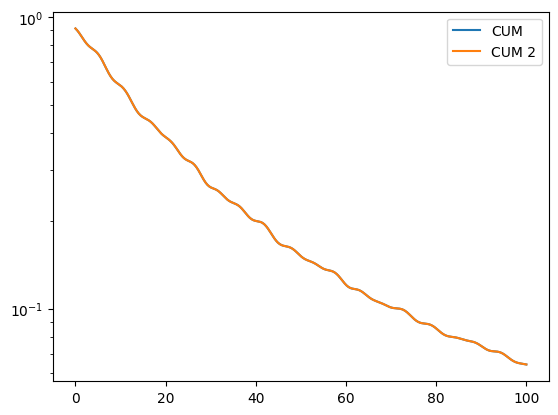

In [25]:
#plt.plot(times,sdd-np.min(A.eigenenergies()),label="HEOM")
#plt.plot(times, sddbr-np.min(A.eigenenergies()),label="BR")
plt.plot(times, sddcum-np.min(A.eigenenergies()), label="CUM")#plt.axhline(y=0)
plt.plot(times, sddcum2-np.min(A.eigenenergies()),
         label="CUM 2")  # plt.axhline(y=0)

plt.yscale("log")
plt.legend()

In [ ]:
Just curious as to which approach is working better here

In [26]:
cum.gamma_gen(batho,1,1,1)

(0.25525214289707127+0j)

In [27]:
cum.gamma_gen(bath, 1,1,1)*np.pi**4

(78.11217226503301+0j)

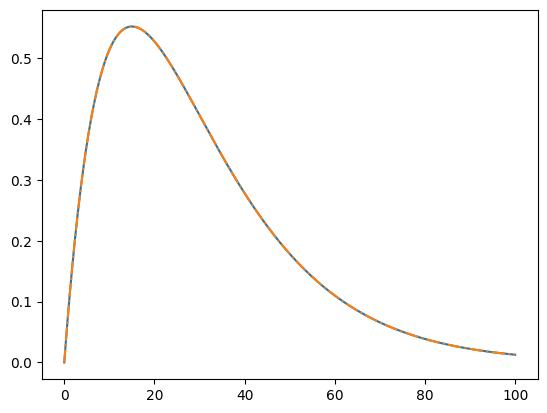

In [28]:
plt.plot(times,bath.spectral_density(times))
plt.plot(times,batho.spectral_density(times)*np.pi,"-.")

In [29]:
tr_cum = [qt.tracedist(result_cum[i], result.states[i])
          for i in range(len(result.states))]
tr_br = [qt.tracedist(resultBR.states[i],result.states[i]) for i in range(len(result.states))]
tr_br2 = [qt.tracedist(resultBR2.states[i], result.states[i]) for i in range(len(result.states))]

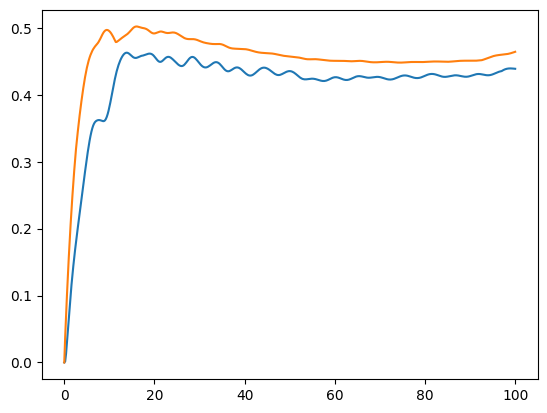

In [30]:
plt.plot(times, tr_cum)
plt.plot(times, tr_br)

and Fidelity

In [31]:
f_cum = [qt.fidelity(result_cum[i], result.states[i])
          for i in range(len(result.states))]
f_br = [qt.fidelity(resultBR.states[i], result.states[i]) for i in range(len(result.states))]
f_br2 = [qt.fidelity(resultBR2.states[i], result.states[i])
        for i in range(len(result.states))]

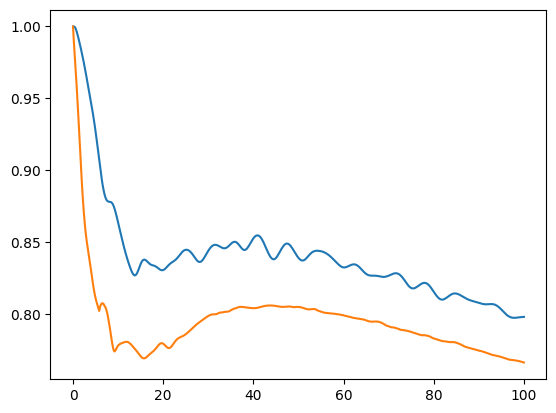

In [32]:
plt.plot(times, f_cum)
plt.plot(times, f_br)

This lead me to believe that br has a problem (I tried with a lower hierarchy first and it seemed a bit strange)

In [33]:
np.min([np.min(i.eigenenergies()) for i in resultBR.states])

-0.010926526714434733

Negative Eigenvalues win for my approach

In [34]:
np.min([np.min(i.eigenenergies()) for i in result_cum])

0.0

Te comparison might be meaningless here then though as if it's not completely positive tr and fid might be bigger than 1
so BR could show that it is better even when it is not. Based on this led us do the secular approximation to recover a bit of
positivity

In [35]:
np.min([np.min(i.eigenenergies()) for i in resultBR2.states]) #basically positive

-1.0752774044082483e-08

In [36]:
z=A.eigenenergies()
z[0]-z[1] #About the size of the gap I guess too hard of a model

-2.220446049250313e-16

Did heom converged to Physical states?

In [37]:
np.min([np.min(i.eigenenergies()) for i in result.states])  # basically positive

-1.441957949762287e-10

If not, go back and make better numerics

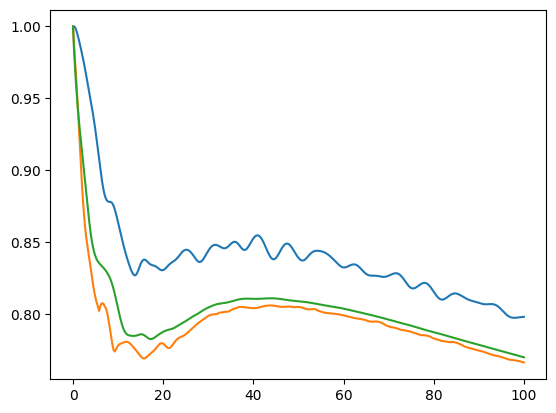

In [38]:
plt.plot(times, f_cum)
plt.plot(times, f_br)
plt.plot(times, f_br2)

Same thing but underdamped spectral density

In [39]:
# Raise this question about the paper / I consider this cheating # Negativity happens when This value is too small
E01 = A.eigenenergies()[2]-A.eigenenergies()[0]
print(E01)
w0=5*E01
gamma=w0/3
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2 +0j)
lam=np.sqrt(Omega)/24
print(lam)

0.18748855133280806
(0.040059223158995835+0j)


/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:925: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om + 1.0j * Gamma) / 2)),
/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:927: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om - 1.0j * Gamma) / 2)),


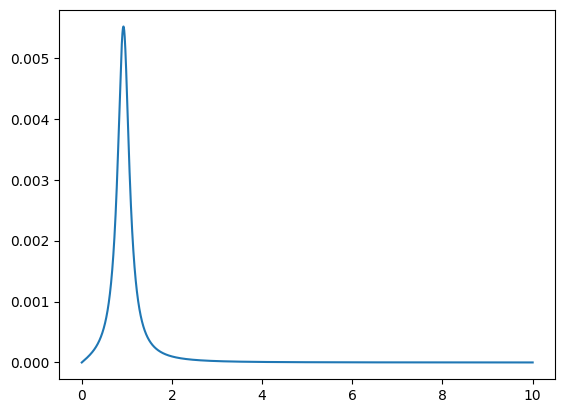

In [40]:
# functions don't take zero because 1/T should be fixed
bath = heom.UnderDampedBath(Q=psis[0], lam=lam, gamma=gamma, w0=w0, T=0, Nk=5)
times2 = np.linspace(0,10,5000)
plt.plot(times2,bath.spectral_density(times2))

In [41]:
lam

(0.040059223158995835+0j)

In [42]:
2*w0>gamma

True

In [43]:
bath=heom.UnderDampedBath(Q=psis[0],lam=lam,gamma=gamma,w0=w0,T=0,Nk=5) # functions don't take zero because 1/T should be fixed 
times2=np.linspace(0,50,1000)
cfiitter2=heom.CorrelationFitter(psis[0],0,times2,bath.correlation_function)
bath1,fit2info=cfiitter2.get_fit(Ni=1,Nr=2)
print(fit2info['summary']) #notice one mode is also a pretty good approximation

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-8.89e-05 |-7.40e-01 |3.16e-24                              | 1         |-8.68e-04 |-1.56e-01 |9.24e-01                              
 2         | 8.74e-04 |-1.57e-01 |9.24e-01                              |                                                                        
                                                                        |A  normalized RM

In [44]:
times2 = np.linspace(0, 100, 500)

cvis = bath.correlation_function(times2)

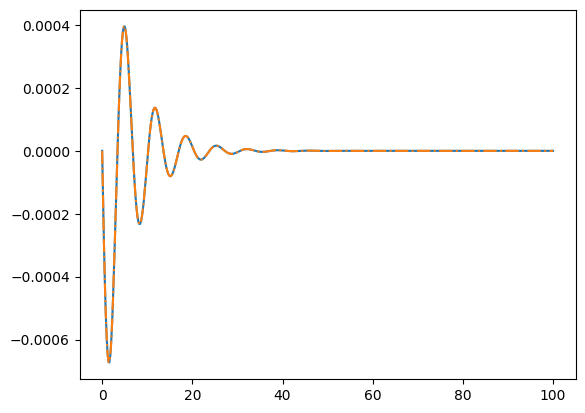

In [45]:
plt.plot(times2, np.imag(cvis))
plt.plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.")
plt.show()

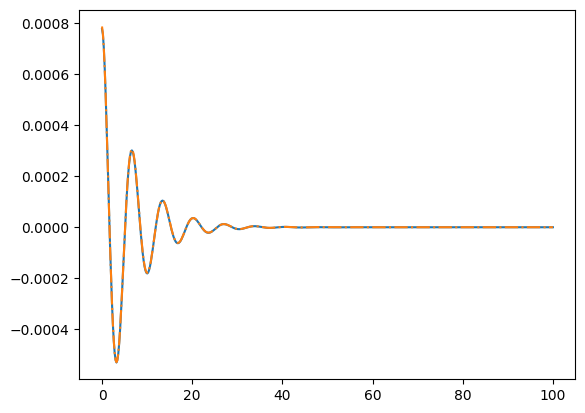

In [46]:
plt.plot(times2, np.real(cvis))
plt.plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.")
plt.show()

In [47]:
times = np.linspace(0, 100, 500)

solver = heom.HEOMSolver(A,
                    [bath1], max_depth=8,options={"atol":1e-14})
result = solver.run(rho0, times)

10.0%. Run time:  14.92s. Est. time left: 00:00:02:13
20.0%. Run time:  33.87s. Est. time left: 00:00:02:15
30.1%. Run time:  53.58s. Est. time left: 00:00:02:04
40.1%. Run time:  73.10s. Est. time left: 00:00:01:49
50.1%. Run time:  93.36s. Est. time left: 00:00:01:32
60.1%. Run time: 112.26s. Est. time left: 00:00:01:14
70.1%. Run time: 130.31s. Est. time left: 00:00:00:55
80.2%. Run time: 148.33s. Est. time left: 00:00:00:36
90.2%. Run time: 166.28s. Est. time left: 00:00:00:18
100.0%. Run time: 184.09s. Est. time left: 00:00:00:00
Total run time: 184.09s


In [48]:
sdd2=[(i*A).tr() for i in result.states]

In [49]:
result.states[-1]

Quantum object: dims=[[4, 2], [4, 2]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[ 1.73738749e-02+5.47758927e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  6.47325844e-02-7.92670844e-02j
   0.00000000e+00+0.00000000e+00j -1.68780228e-02+5.05773467e-02j
   1.51390206e-02-4.20508173e-02j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.82058007e-02-2.60901552e-18j
   7.04534494e-03+1.20914563e-02j  0.00000000e+00+0.00000000e+00j
  -5.10497156e-03+1.17909311e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  5.82089204e-04-2.53554971e-03j]
 [ 0.00000000e+00+0.00000000e+00j  7.04534494e-03-1.20914563e-02j
   1.94094475e-02-2.14417659e-18j  0.00000000e+00+0.00000000e+00j
   5.34438584e-03+8.15882452e-03j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -9.93791237e-03+3.20993183e-03j]
 [ 6.47325844e-02+7.92670844e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  6.17080434e-01

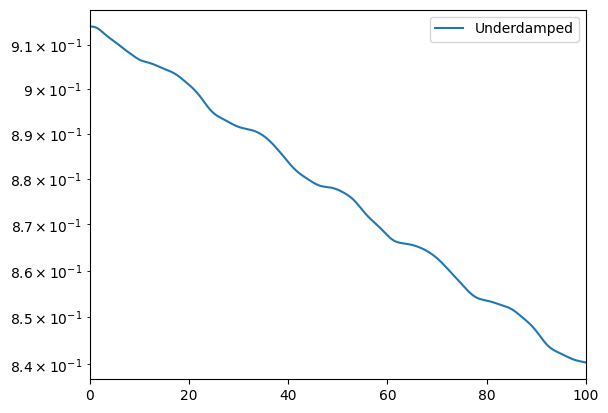

In [50]:
#plt.plot(times,sdd-np.min(A.eigenenergies()),label="Ohmic")
plt.plot(times,sdd2-np.min(A.eigenenergies()),label="Underdamped")
plt.yscale("log")
plt.xlim(0,100)
plt.legend()

Let us try not to cheat with E01

In [51]:
E01=2#A.eigenenergies()[2]-A.eigenenergies()[0]# Raise this question about the paper / I consider this cheating
gamma=1
w0=1.2*E01
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2 +0j)
lam=1.15*np.sqrt(Omega)

In [52]:
bath2=heom.UnderDampedBath(Q=psis[0],lam=lam,gamma=gamma,w0=w0,T=0,Nk=5) # functions don't take zero because 1/T should be fixed
times2=np.linspace(0,25,2000)
cfiitter2=heom.CorrelationFitter(psis[0],0,times2,bath2.correlation_function)
fit2=cfiitter2.get_fit(Ni=1,Nr=2)
print(fit2[1]['summary']) #notice one mode is also a pretty good approximation

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 3.60e-01 |-4.42e-01 |2.48e+00                              | 1         |-6.61e-01 |-5.00e-01 |2.35e+00                              
 2         | 2.37e-01 |-3.80e-01 |2.19e+00                              |                                                                        
                                                                        |A  normalized RM

In [53]:
solver = heom.HEOMSolver(A,
                    [fit2[0]], max_depth=6,options={"atol":1e-14})
result2 = solver.run(rho0, times)

10.0%. Run time:  12.90s. Est. time left: 00:00:01:55
20.0%. Run time:  27.78s. Est. time left: 00:00:01:50
30.1%. Run time:  47.11s. Est. time left: 00:00:01:49
40.1%. Run time:  62.90s. Est. time left: 00:00:01:34
50.1%. Run time:  74.14s. Est. time left: 00:00:01:13
60.1%. Run time:  87.14s. Est. time left: 00:00:00:57
70.1%. Run time:  98.48s. Est. time left: 00:00:00:41
80.2%. Run time: 107.38s. Est. time left: 00:00:00:26
90.2%. Run time: 115.38s. Est. time left: 00:00:00:12
100.0%. Run time: 123.25s. Est. time left: 00:00:00:00
Total run time: 123.26s


In [54]:
sdd3=[(i*A).tr() for i in result.states]

Add BR and Cum for underdamped

In [55]:
from nmm import UnderdampedBath

In [56]:
cum = csolve(
    Hsys=A, t=times, baths=[bath],
    Qs=[psis[0]],
    eps=1e-12, cython=False)

In [57]:
result_cum = cum.evolution(rho0)
result_cum = rotation(result_cum,A,times)

Computing Exponential of Generators . . . .: 100%|██████████| 500/500 [00:00<00:00, 767.58it/s]


In [58]:

a_ops = [[psis[0], bath.power_spectrum]]
resultBR = qt.brmesolve(A, rho0, times, a_ops=a_ops, options={
                        "atol": 1e-14}, sec_cutoff=-1)

a_ops = [[psis[0], bath.power_spectrum]]
resultBR2 = qt.brmesolve(A, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14})

In [59]:
sddbr = [(i*A).tr() for i in resultBR.states]
sddcum = [(i*A).tr() for i in result_cum]
sddbr2 = [(i*A).tr() for i in resultBR2.states]

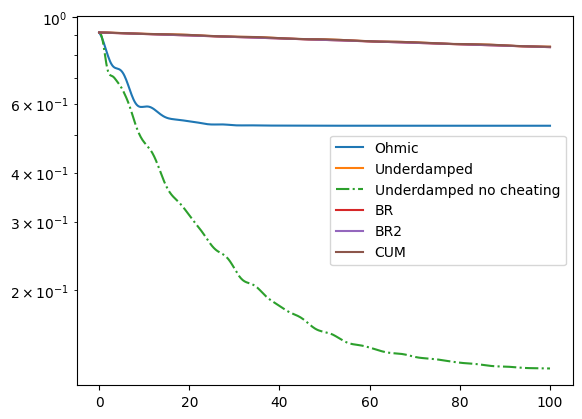

In [78]:
plt.plot(times,sdd-np.min(A.eigenenergies()),label="Ohmic")
plt.plot(times,sdd2-np.min(A.eigenenergies()),label="Underdamped")
plt.plot(times,sdd3-np.min(A.eigenenergies()),label="Underdamped no cheating",linestyle="-.")
plt.plot(times, sddbr-np.min(A.eigenenergies()), label="BR")
plt.plot(times, sddbr2-np.min(A.eigenenergies()), label="BR2")
plt.plot(times, sddcum-np.min(A.eigenenergies()),
         label="CUM")  # plt.axhline(y=0)

plt.yscale("log")
plt.legend()

In [68]:
f_cum = [qt.fidelity(result_cum[i], result.states[i])
         for i in range(len(result.states))]
f_br = [qt.fidelity(resultBR.states[i], result.states[i])
        for i in range(len(result.states))]
f_br2 = [qt.fidelity(resultBR2.states[i], result.states[i])
         for i in range(len(result.states))]

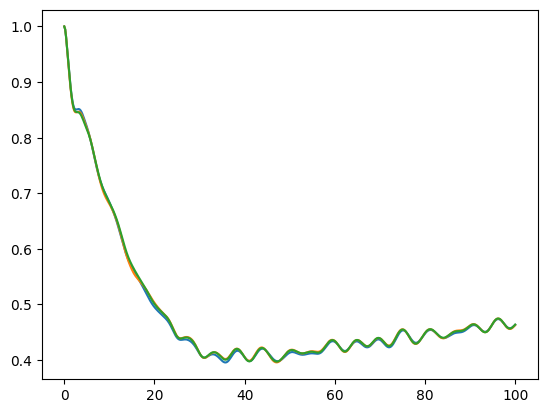

In [69]:
plt.plot(times, f_cum)
plt.plot(times, f_br)
plt.plot(times, f_br2)

In [70]:
def population(states,i=2,j=2):
    return [k[i,j] for k in states]

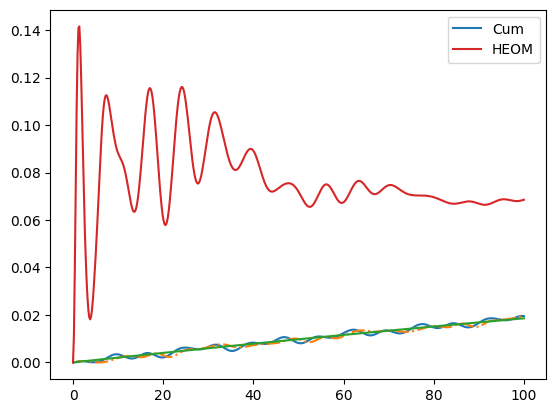

In [73]:
plt.plot(times, population(result_cum),label="Cum")
plt.plot(times, population(resultBR.states),"-.")
plt.plot(times, population(resultBR2.states))
plt.plot(times, population(result.states),label="HEOM")
plt.legend()
plt.show()

In [74]:
tr_cum = [qt.tracedist(result_cum[i], result.states[i])
         for i in range(len(result.states))]
tr_br = [qt.tracedist(resultBR.states[i], result.states[i])
        for i in range(len(result.states))]
tr_br2 = [qt.tracedist(resultBR2.states[i], result.states[i])
         for i in range(len(result.states))]

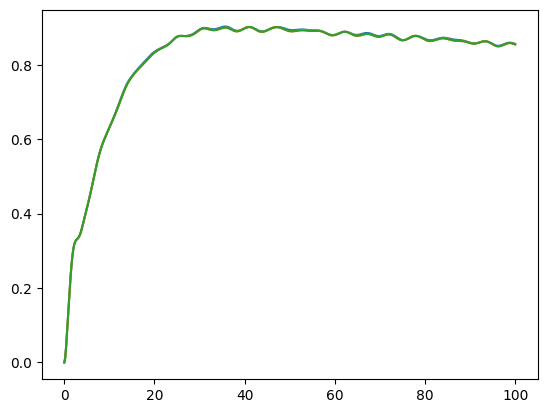

In [75]:
plt.plot(times, tr_cum)
plt.plot(times, tr_br)
plt.plot(times, tr_br2)

In [67]:
def prepare_states(
        H, Q, E01, rho0, times=np.linspace(0, 25, 5000),
        Ni=1, Nr=2,Nc=3):
    # Raise this question about the paper / I consider this cheating
    gamma = E01/2
    w0 = 2*E01
    Gamma = gamma/2
    Omega = np.sqrt(w0**2 - Gamma**2 + 0j)
    lam = 1.15*np.sqrt(Omega)
    # functions don't take zero because 1/T should be fixed
    bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5)
    cfiitter2 = heom.CorrelationFitter(
        Q, 0, times, bath.correlation_function)
    bath1, fit2info = cfiitter2.get_fit(Ni=Ni, Nr=Nr)
    # notice one mode is also a pretty good approximation
    print(fit2info['summary'])
    times2 = times[0:-1:10]
    cvis = bath.correlation_function(times2)
    plt.plot(times2, np.imag(cvis))
    plt.plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.")
    plt.show()
    solver = heom.HEOMSolver(H,
                             [bath1], max_depth=Nc, options={"atol": 1e-14})
    result = solver.run(rho0, times)
    cum = csolve(
        Hsys=H, t=times, baths=[bath],
        Qs=[Q],
        eps=1e-4, cython=False)

    a_ops = [[Q, bath.power_spectrum]]
    resultBR = qt.brmesolve(H, rho0, times, a_ops=a_ops, options={
                            "atol": 1e-14}, sec_cutoff=-1)

    a_ops = [[Q, bath.power_spectrum]]
    resultBR2 = qt.brmesolve(H, rho0, times, a_ops=a_ops, options={
        "atol": 1e-14})
    return result, cum, resultBR,resultBR2